In [70]:
import paddle
import paddle.nn.functional as F
from paddle.nn import Conv1D, MaxPool1D, BatchNorm1D, Linear, Conv2D, MaxPool2D, BatchNorm2D, Dropout, LSTM, AvgPool2D

class CQTDataset(paddle.io.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        data = self.data[index]

        return data

    def __len__(self):
        return len(self.data)

class conv_block(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(conv_block, self).__init__()
        self.conv = Conv2D(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, padding=padding)
        self.bn = BatchNorm2D(out_channels)
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = F.relu(out)
        return out

class base_line(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(base_line, self).__init__()
        self.head = paddle.nn.Sequential(
            # 可以将卷积层改为一维或二维进行测试
            conv_block(1, 32, 7, 3),
            MaxPool2D([1,2],[1,2]),
            conv_block(32, 32, 7, 3),
            MaxPool2D([1,4],[1,4]),
            conv_block(32, 512, [1,1], [0,0]),
            MaxPool2D([1,11],[1,11]),
            conv_block(512, 512, [1,1], [0,0]),
            Conv2D(512, num_labels, (1,1), padding=(0,0)),
            )
        

    def forward(self, x):
        x = self.head(x)
        return x

class LsBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, num_layers, features_num=1):
        super(LsBlock, self).__init__()
        self.out_channels = out_channels
        self.ls1 = LSTM(input_size=in_channels*features_num, hidden_size=out_channels*features_num, num_layers=num_layers, direction="bidirect")
        self.lsbn1 = BatchNorm2D(in_channels*features_num*2)
        self.pool1 = AvgPool2D([2,1],[2,1])
        self.bn = BatchNorm2D(out_channels)
        self.lsconv = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,3], stride=[2*features_num,1], padding=[0,1])

    def forward(self, x):
        x = x.reshape([x.shape[0], -1, x.shape[3]])  # LSTMtemp
        x = paddle.transpose(x, perm=[0, 2, 1])  # 维度交换
        x, (h, c) = self.ls1(x) #LSTM
        x = x.reshape([x.shape[0], x.shape[1], -1, self.out_channels])
        x = paddle.transpose(x, perm=[0, 3, 2, 1])  # 还原维度
        x = self.lsconv(x)
        x = self.bn(x)
        
        return x

class ResBlock(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, features_num=1):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.features_num = features_num
        # in_channels, 卷积层的输入通道数
        # out_channels, 卷积层的输出通道数
        # stride, 卷积层的步幅
        # 创建第一个卷积层 1x1
        self.bn1 = BatchNorm2D(in_channels)
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])
        self.bn2 = BatchNorm2D(out_channels)
        self.conv2 = Conv2D(in_channels=out_channels, out_channels=out_channels, kernel_size=[1,3], stride=1, padding=[0,1])

        self.sk = Conv2D(in_channels=in_channels, out_channels=out_channels, kernel_size=[1,1], padding=[0,0])

    def forward(self, y):
        self.temp = y  # Restemp
        
        y = self.bn1(y)
        y = self.conv1(y)
        y = self.bn2(y)
        y = F.relu(y)
        y = self.conv2(y)
        y = self.bn2(y)

        y = paddle.add(y, self.sk(self.temp))
        return y

class base_line_res(paddle.nn.Layer):
    def __init__(self, num_classes=1 , resnum=8):
        super(base_line_res, self).__init__()
        self.head = paddle.nn.Sequential(
                BatchNorm2D(bins),       
                # 视野为5的二维卷积核
                Conv2D(bins, bins, 5, padding=2),
                ResBlock(bins, bins*2),
                Dropout(p=0.2),
                MaxPool2D([2,1],[2,1]),
                ResBlock(bins*2, bins*3),
                Dropout(p=0.2),
                MaxPool2D([3,1],[3,1]),
                ResBlock(bins*3, bins*3),
                BatchNorm2D(bins*3),
                paddle.nn.ReLU(),
                Conv2D(bins*3, num_labels, [3, 1], padding=[1, 0]))
        
    def forward(self, x):
        x = self.head(x)
        return x


class DRNet(paddle.nn.Layer):
    def __init__(self, num_classes=1 , resnum=8):
        super(DRNet, self).__init__()
        self.head = paddle.nn.Sequential(
                BatchNorm2D(bins),
                LsBlock(bins, bins, 1, features_num=features_num),
                Conv2D(bins, bins, [1, 5], padding=[0, 2]),
                ResBlock(bins, bins*2, features_num=features_num),
                Dropout(p=0.2),
                MaxPool2D([2,1],[2,1]),
                ResBlock(bins*2, bins*3),
                Dropout(p=0.2),
                MaxPool2D([3,1],[3,1]),
                ResBlock(bins*3, bins*3),
                BatchNorm2D(bins*3),
                LsBlock(bins*3, bins*3, 2, 1),
                BatchNorm2D(bins*3),
                paddle.nn.ReLU(),
                Conv2D(bins*3, num_labels, [3, 1], padding=[1, 0]))
        
    def forward(self, x):
        x = self.head(x)
        return x


In [71]:
import numpy as np

path = "output/"
predictfile = "Predict.npy"
pitchfile="Predict_pitch.npy"
outputfile="春节序曲.svg"

data = np.load(predictfile)

har_num = 3  # 最高泛音序列倍数(务必>1，因为这里代表的是倍数，1倍等于没有变化)
batch_size = 100
num_labels = 11
modelid = 2  # 0: base_line, 1:base_line with resblock, 2: DRNet
order_difference = 2  # 差分次数
best_threshold = 0.32

odsum = []
pitch = []
cqcc = []

print(data.shape)

(102, 88, 258)


In [72]:
delx = []
for i in range(order_difference):
    if i == 0:
        delx = data
    delx = np.diff(delx, 1, axis=2)
    temp = np.zeros([data.shape[0], data.shape[1], 1])
    delx = np.concatenate([temp, delx], axis=2)
    odsum.append((np.array(delx)).astype("float32"))
delx = None
odsum = np.array(odsum)
odsum = odsum.reshape([data.shape[0], data.shape[1], order_difference, data.shape[2]])

In [73]:

import math

def pitchnorm(pitch, har_num, Thre=False):
    # 泛音序列处理，先读取泛音序列，之后便不再考虑该数组
    minum = np.min(pitch)
    maxum = np.max(pitch)
    temp_pitch = pitch
    for i in range(har_num - 1):
        times = int(math.log2(i + 2) * 12)
        temp = np.roll(pitch, times, axis=1)
        temp[:, :times, :] = minum
        temp_pitch += temp

    pitch = temp_pitch
    temp_pitch = []
    # 归一化
    pitch = pitch/(maxum - minum)
    # 二值化
    if Thre:
        pitch = np.int64(data>0.5)
    return pitch

pitch = np.load(pitchfile)
pitch = pitchnorm(pitch, har_num)
pitch = pitch.reshape([pitch.shape[0], pitch.shape[1], 1, pitch.shape[2]])

In [74]:
# cqcc
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

cqcc = np.zeros(data.shape)
cqcc = cqcc.astype('float32')
with tqdm(total=data.shape[0]) as pbar:
    for i in range(data.shape[0]):
        cqcc[i] = cv2.dct(data[i])
        pbar.update(1)
        
cqcc = cqcc.reshape([data.shape[0], data.shape[1], 1, data.shape[2]])
print(cqcc.shape)


100%|██████████| 102/102 [00:00<00:00, 1460.55it/s]

(102, 88, 1, 258)


In [75]:
print(data.shape, pitch.shape, cqcc.shape, odsum.shape)

(102, 88, 258) (102, 88, 1, 258) (102, 88, 1, 258) (102, 88, 2, 258)


In [76]:
def reshac(data):
    if modelid == 0:
        data = data.reshape([data.shape[0], 1, data.shape[2], data.shape[1]])
    else:
        data = data.reshape([data.shape[0], data.shape[1], 1, data.shape[2]])
    return data

data = reshac(data)
features_num = 1
if len(pitch) != 0:
    data = np.concatenate([data, pitch], axis=2)
    features_num += 1
    pitch = []
if len(cqcc) != 0:
    data = np.concatenate([data, cqcc], axis=2)
    features_num += 1
    cqcc = []
if len(odsum) != 0:
    data = np.concatenate([data, odsum], axis=2)
    features_num += order_difference
    odsum = []

bins = data.shape[1]

print(data.shape)
data = data.astype("float32")
data = data[:100,:,:,:]

(102, 88, 5, 258)


In [77]:
from TrainRunner import Runner
import paddle.nn.functional as F

model = DRNet()
opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters(), weight_decay=1e-4)
use_gpu = True
paddle.device.set_device('gpu:0') if use_gpu else paddle.device.set_device('cpu')

#加载模型的参数
model.set_state_dict(paddle.load(path + "palm.pdparams"))
#加载优化器的参数
opt.set_state_dict(paddle.load(path + "palm.pdopt"))

model.eval()
data = paddle.to_tensor(data)
print(data.shape)
logits = model(data)
pred = F.sigmoid(logits)
pred = np.int64(pred>best_threshold)
pred = paddle.to_tensor(pred)

[100, 88, 5, 258]


In [78]:
ins = [
        "Piano",
        "Harpsichord",
        "Violin",
        "Viola",
        "Cello",
        "String Bass",
        "Bassoon",
        "Clarinet",
        "Flute",
        "Horn",
        "Oboe"]
pred = paddle.transpose(pred, perm=[0, 3, 2, 1])
pred = pred.reshape([-1,11])
print(pred.shape)
pred = pred.numpy()
pred = pred.transpose()

[25800, 11]


0:00:00
0:00:15
0:00:30
0:00:45
0:01:00
0:01:15
0:01:30
0:01:45
0:02:00
0:02:15
0:02:30
0:02:45
0:03:00
0:03:15
0:03:30
0:03:45
0:04:00
0:04:15
0:04:30
0:04:45
0:05:00


<Figure size 640x480 with 0 Axes>

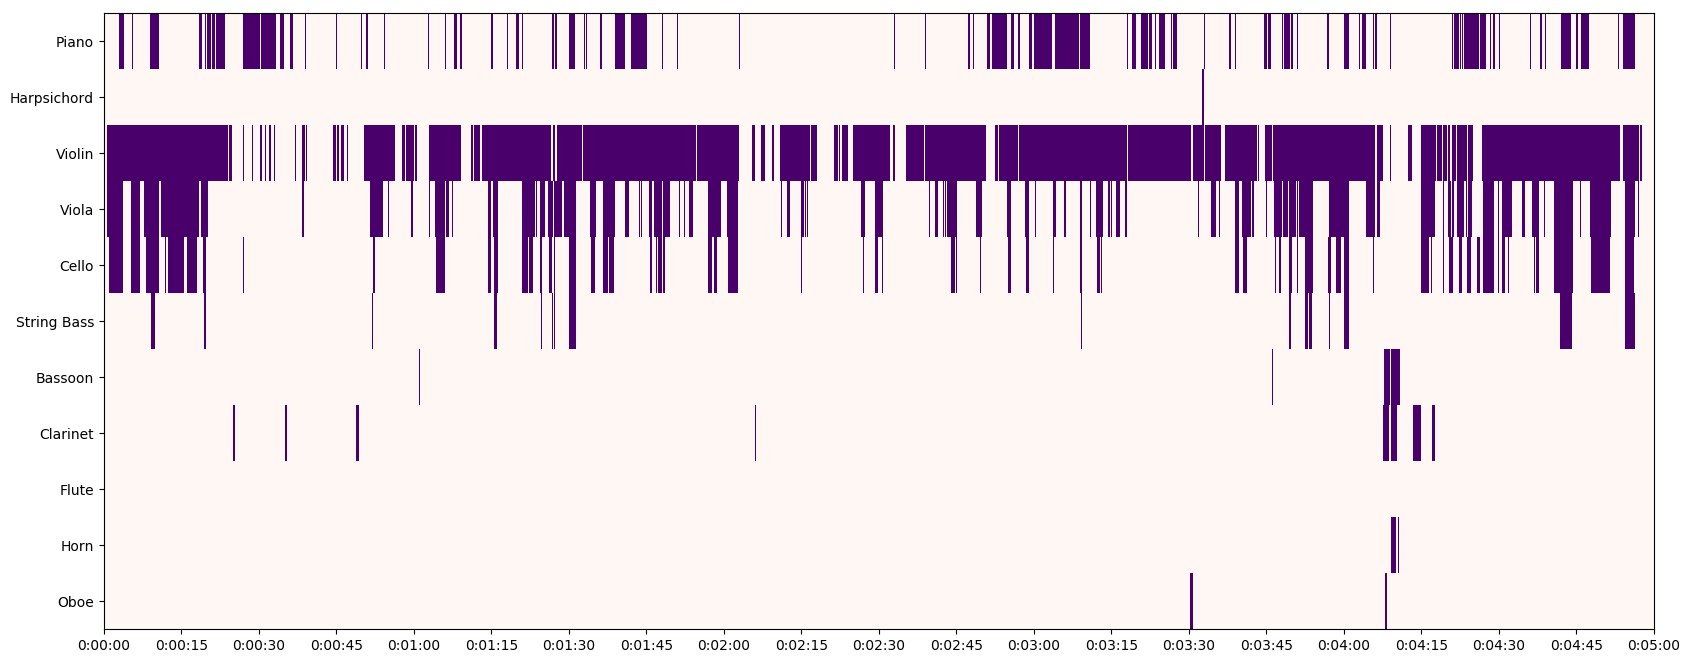

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datetime

plt.figure()
time = [0]
now = 0
for i in range(int(pred.shape[1]/(15*86))+1):
    ConvertedSec = str(datetime.timedelta(seconds = now))
    print(ConvertedSec)
    time.append(ConvertedSec)
    now += 15
    # 每循环一次增加10s

fig, ax = plt.subplots(figsize=(20,8))
pos_list = np.arange(len(ins))
ax.xaxis.set_major_locator(ticker.MultipleLocator(15*86))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((time)))
ax.yaxis.set_major_formatter(ticker.FixedFormatter((ins)))
ax.yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
plt.imshow(pred,cmap=plt.cm.RdPu, interpolation='nearest', aspect='auto')
plt.savefig(outputfile,dip=300,format="svg")
plt.show()